In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_id = test_df['id']

In [4]:
print(f'Info: {train_df.info()}')
print()
print(f'Describe: {train_df.describe()}')
print()
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
Info: None

Describe:                   id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000  

<Axes: >

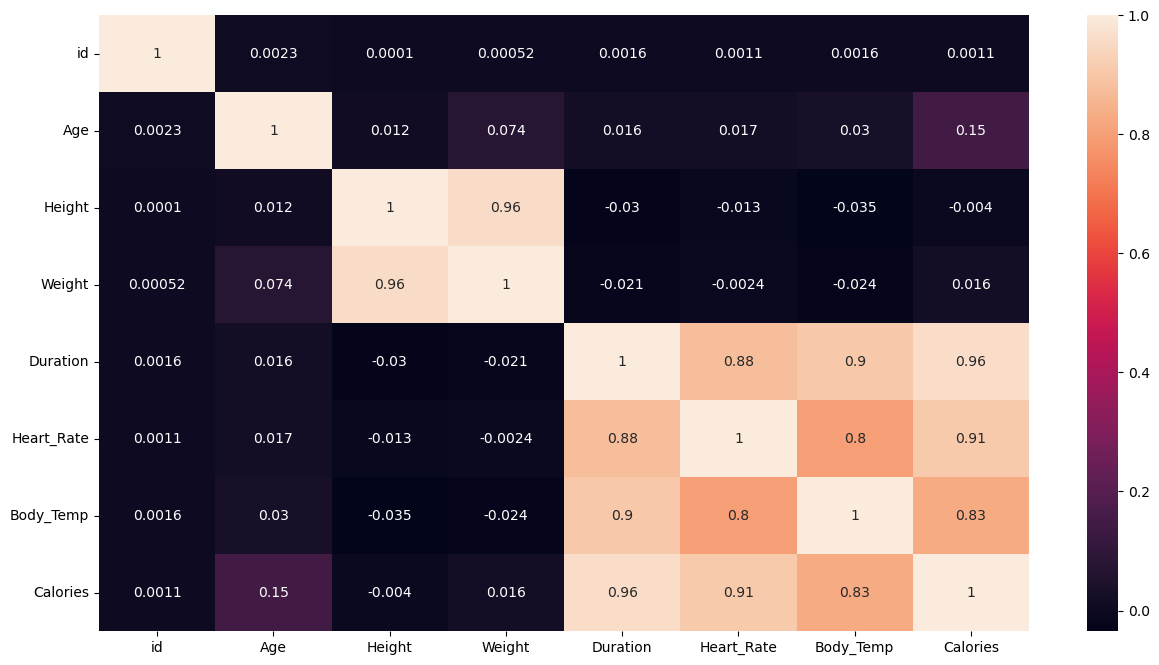

In [5]:
plt.figure(figsize=(15,8))
sns.heatmap(train_df.corr(numeric_only=True), annot=True)

In [6]:
def add_bmi(df):
    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['BMI'] = df['BMI'].round(0)
    return df

def split_by_sex(df):
    male_df = df[df['Sex'] == 'male'].copy()
    female_df = df[df['Sex'] == 'female'].copy()
    return male_df, female_df

def add_columns(df):
    df['IsAge48'] = (df['Age'] == 48).astype(int)
    df['IsAge75_78_Male'] = (df['Age'].isin([75, 76, 77, 78]) & (df['Sex'] == 'male')).astype(int)
    df['IsAge75_78_Female'] = (df['Age'].isin([75, 76, 77, 78]) & (df['Sex'] == 'female')).astype(int)
    
    df['IsShortMale'] = ((df['Sex'] == 'male') & (df['Height'] <= 165)).astype(int)
    df['IstallMale'] = ((df['Sex'] == 'male') & (df['Height'] <= 211)).astype(int)
    df['IsTallFemale'] = ((df['Sex'] == 'female') & (df['Height'] >= 201)).astype(int)

    df['IsBmiHighMale'] = ((df['Sex'] == 'male') & (df['BMI'] >= 36)).astype(int)
    df['IsBmiHighFemale'] = ((df['Sex'] == 'female') & (df['BMI'] >= 33)).astype(int)    

    df['Heart_Rate'] = df['Heart_Rate'].clip(lower=70) # 70보다 작은 애들은 70으로 고정
    df['Intensity'] = (df['Heart_Rate'] - 70) + ((df['Body_Temp'] - 34) * 6).clip(lower=23)
    df['EnergyProxy'] = df['Duration'] * (df['Intensity'] - 23)
    df['Intensity'] = df['Intensity'].clip(lower=23) # 23보다 작은 애들은 23으로 고정
    return df

# def gen_df(df):
#     QT = QuantileTransformer(output_distribution='normal')
#     df['Calories_QT'] = QT.fit_transform(df[['Calories']])
    
#     plt.figure(figsize=(15,10))
#     sns.histplot(df['Calories_QT'], bins=200, kde=True)
#     plt.title('Quantile Calories')
#     plt.show()
#     return df 
    
def drop_cols(df):
    df = df.drop(columns=['id', 'Calories', 'Sex'])
    return df
# 강제로 정규분포에 맞추기


In [7]:
add_bmi(train_df)
male_df, female_df = split_by_sex(train_df)

In [8]:
def plotBoxplot(df, x, y):
    plt.figure(figsize=(30,10))
    sns.boxplot(data=df, x=x, y=y)
    plt.xticks(rotation=45)
    plt.show()

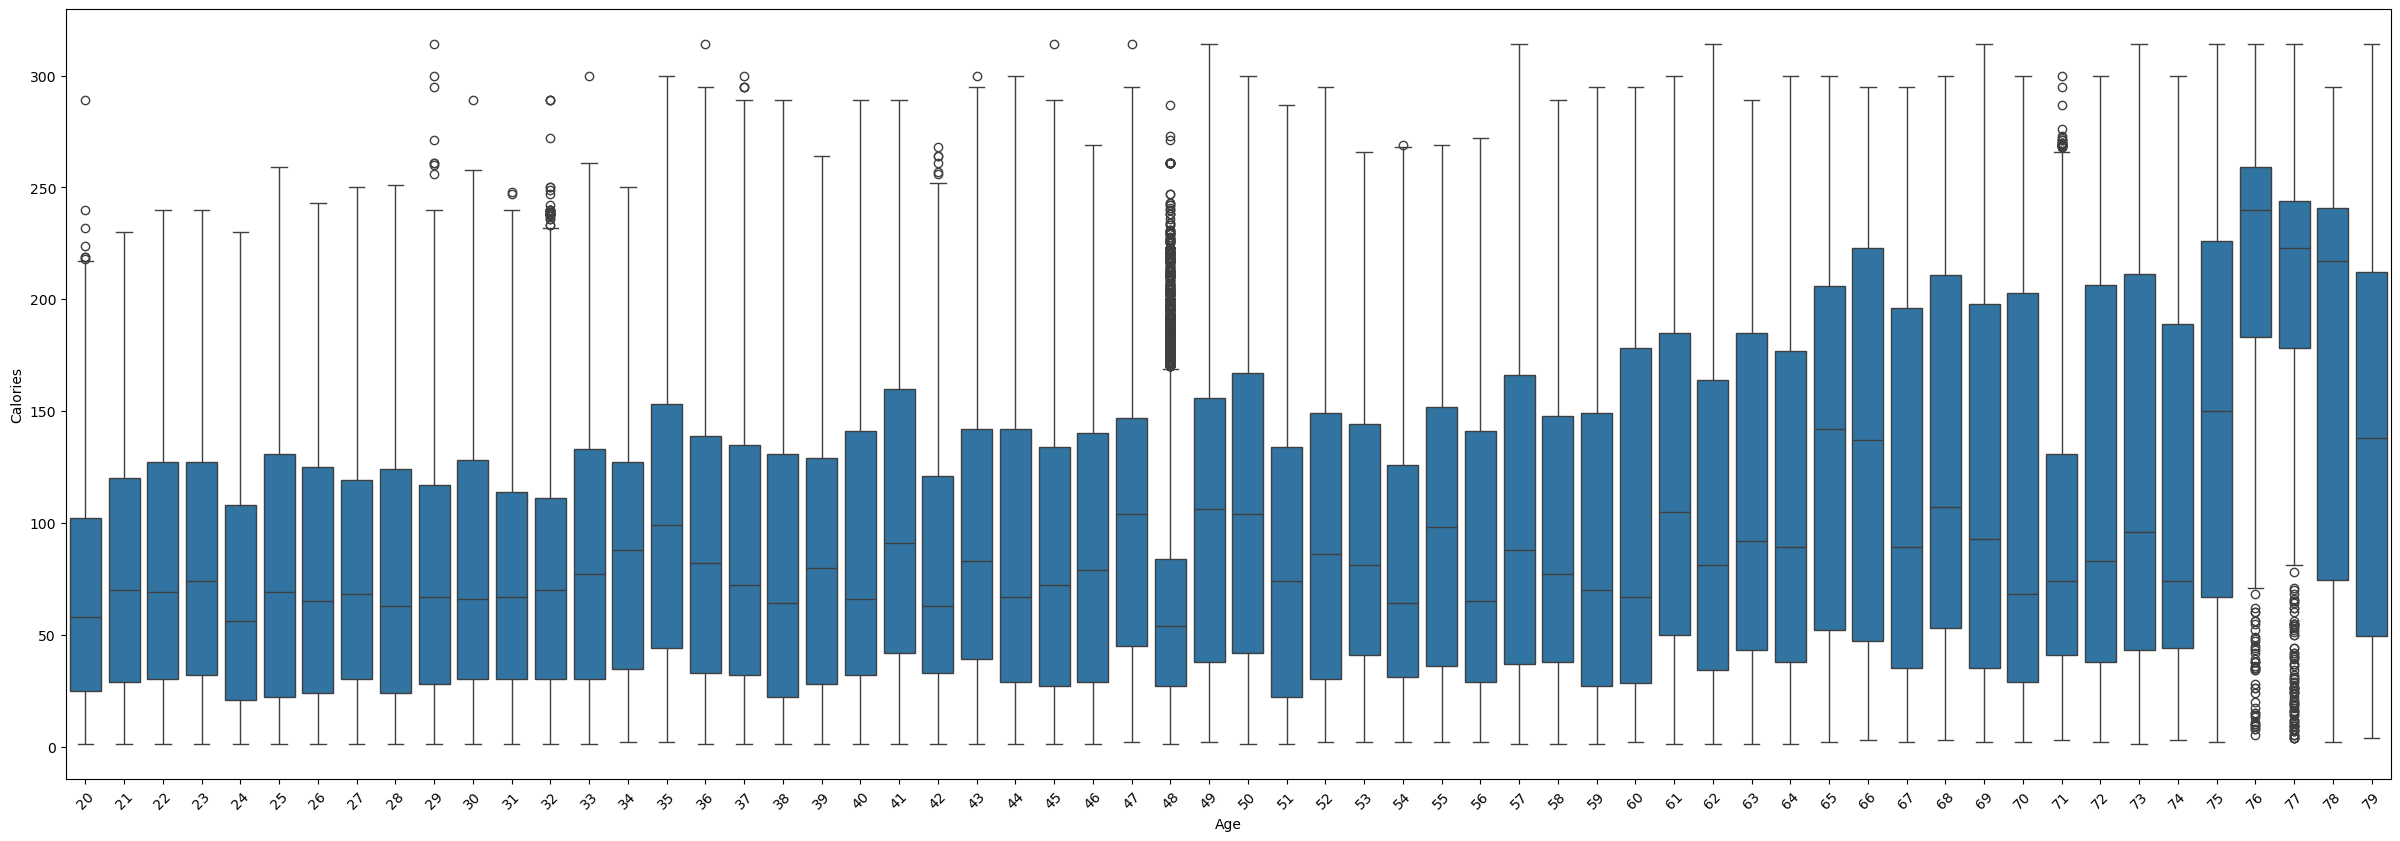

In [9]:
plotBoxplot(male_df, 'Age', 'Calories')

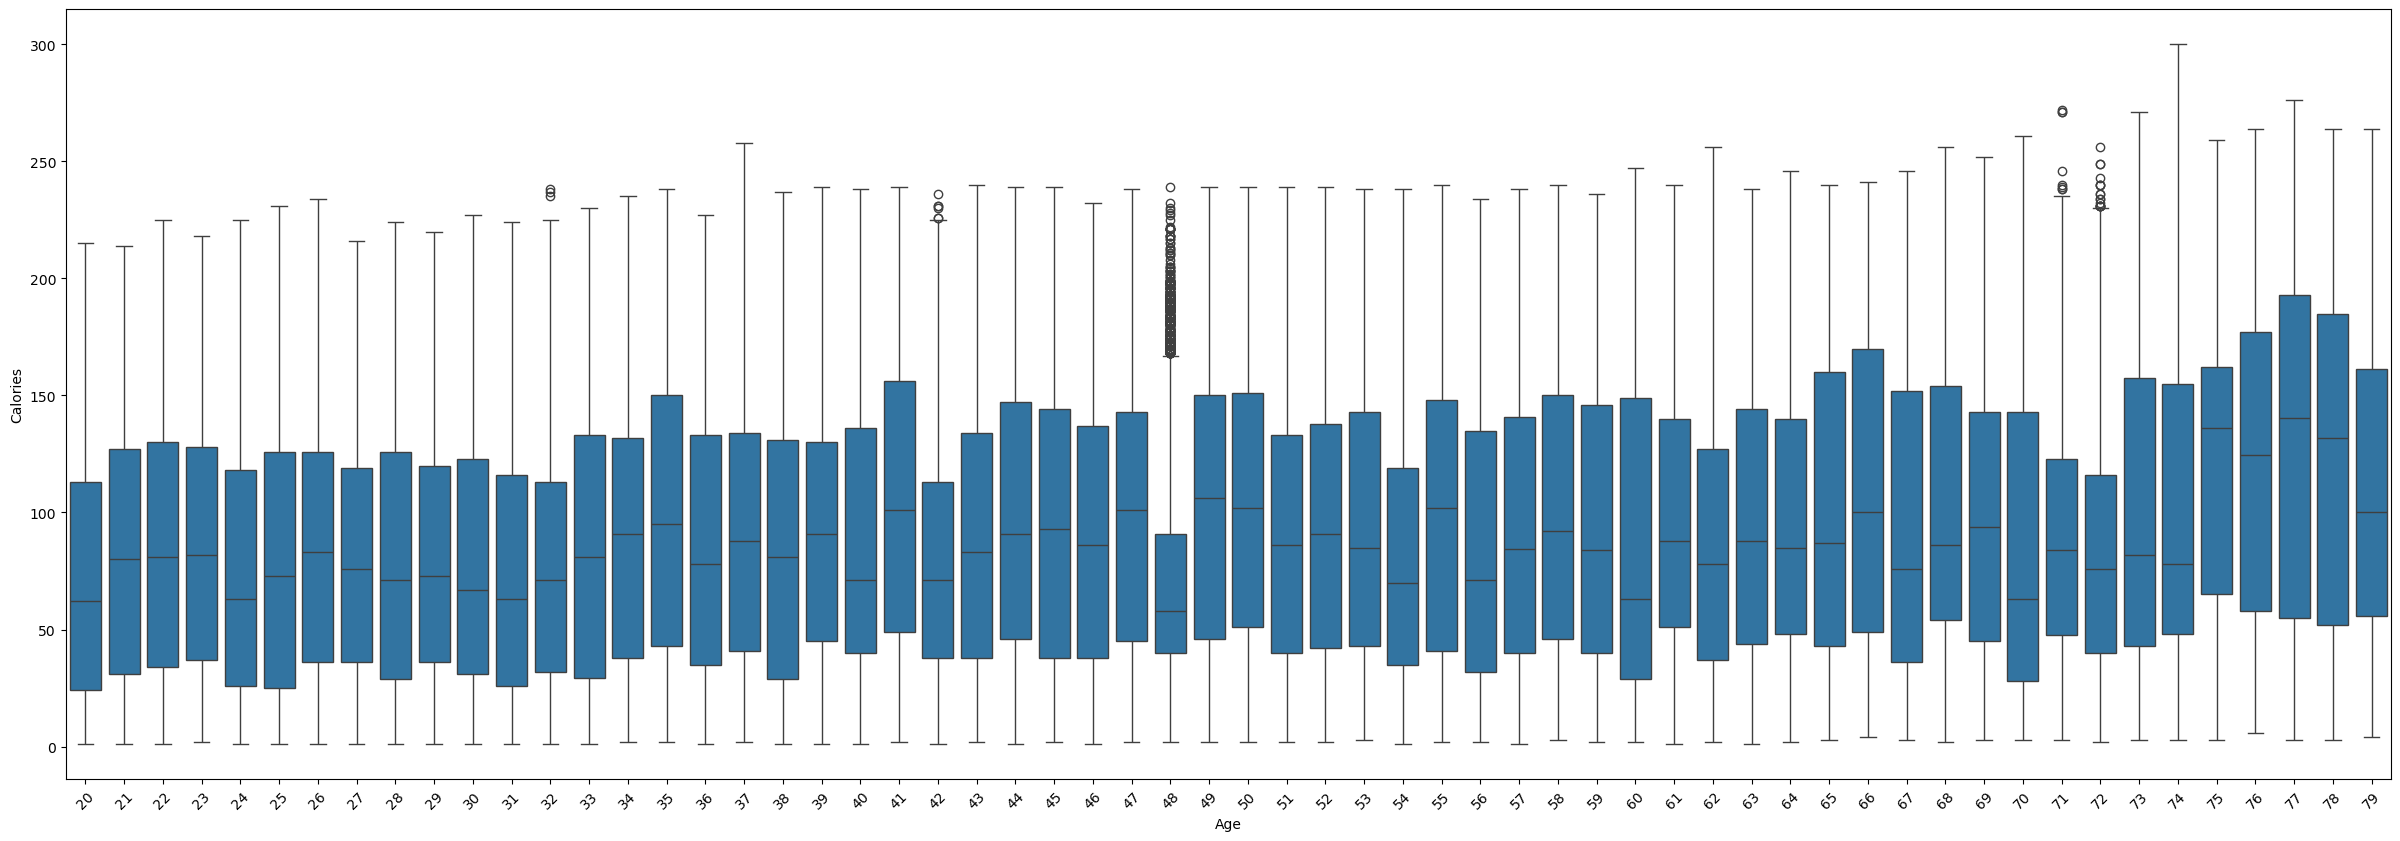

In [10]:
plotBoxplot(female_df, 'Age', 'Calories')

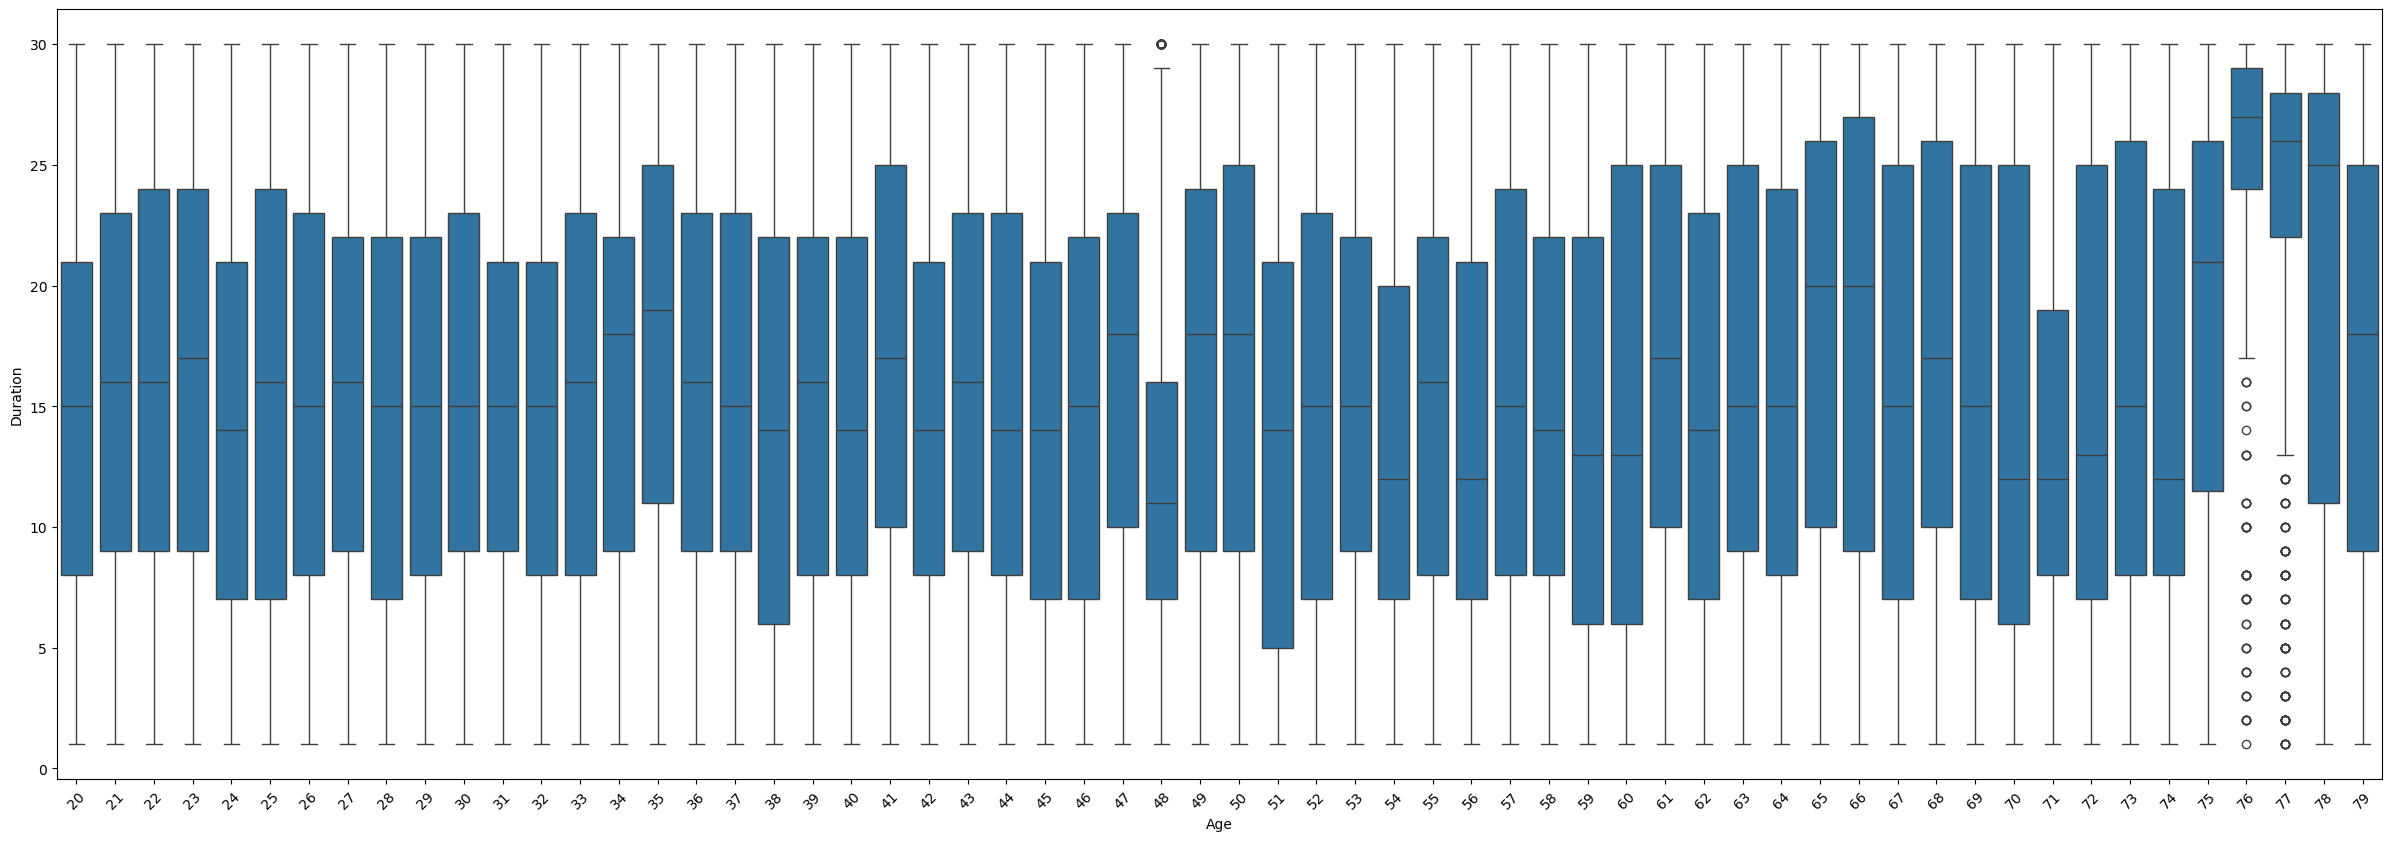

In [11]:
plotBoxplot(male_df, 'Age', 'Duration')

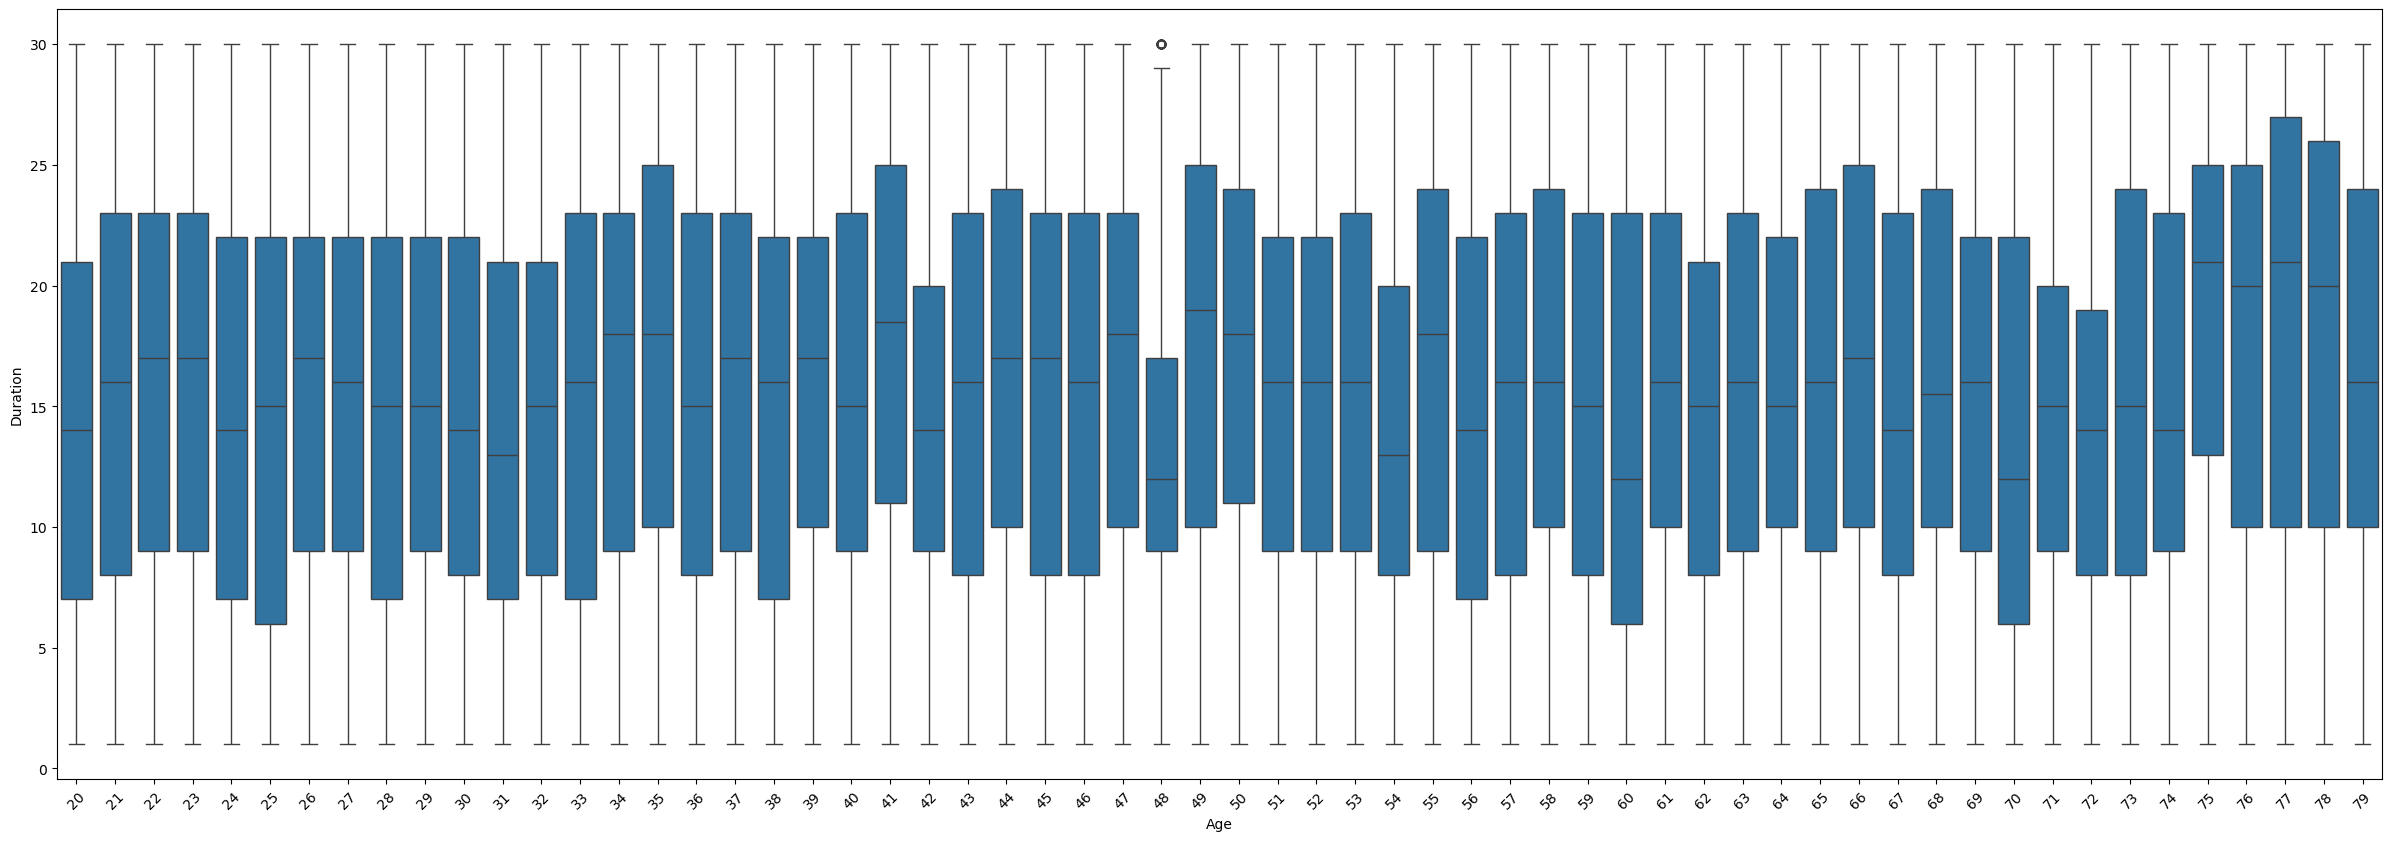

In [12]:
plotBoxplot(female_df, 'Age', 'Duration')

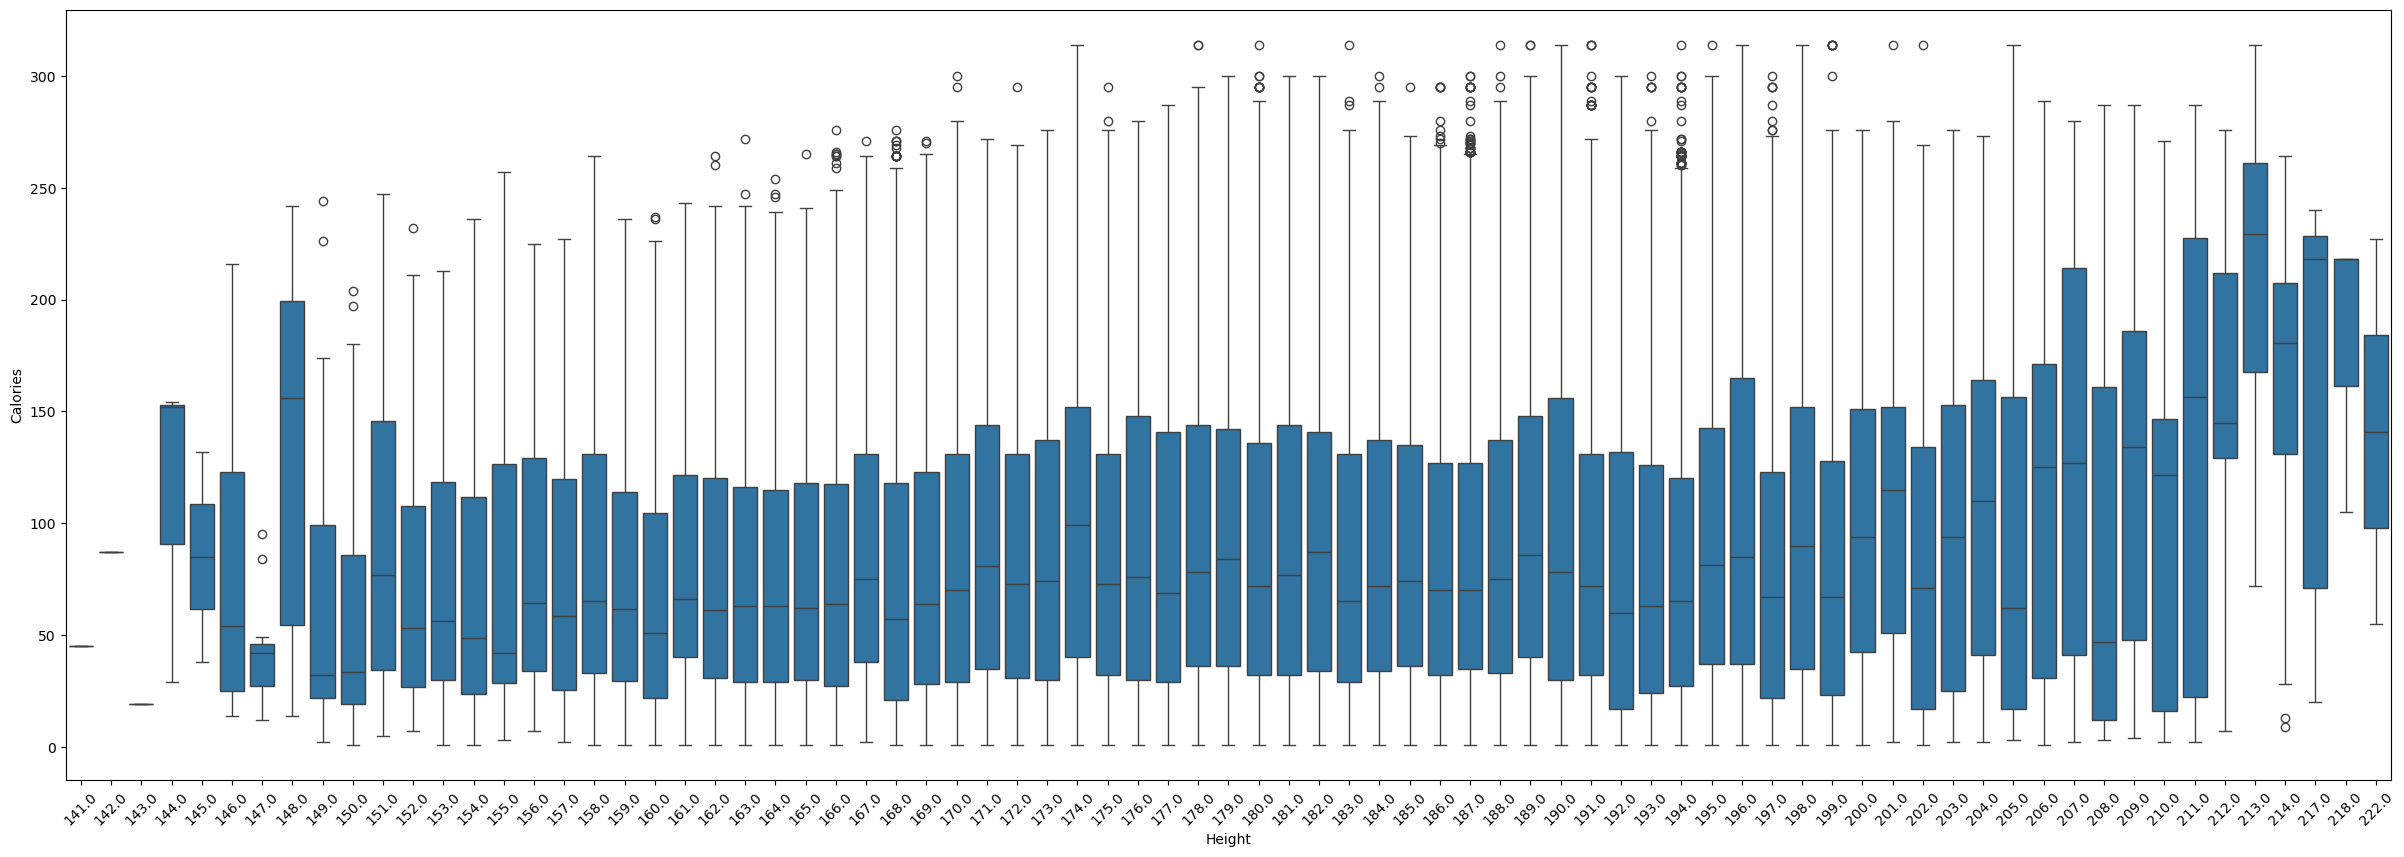

In [13]:
plotBoxplot(male_df, 'Height', 'Calories')

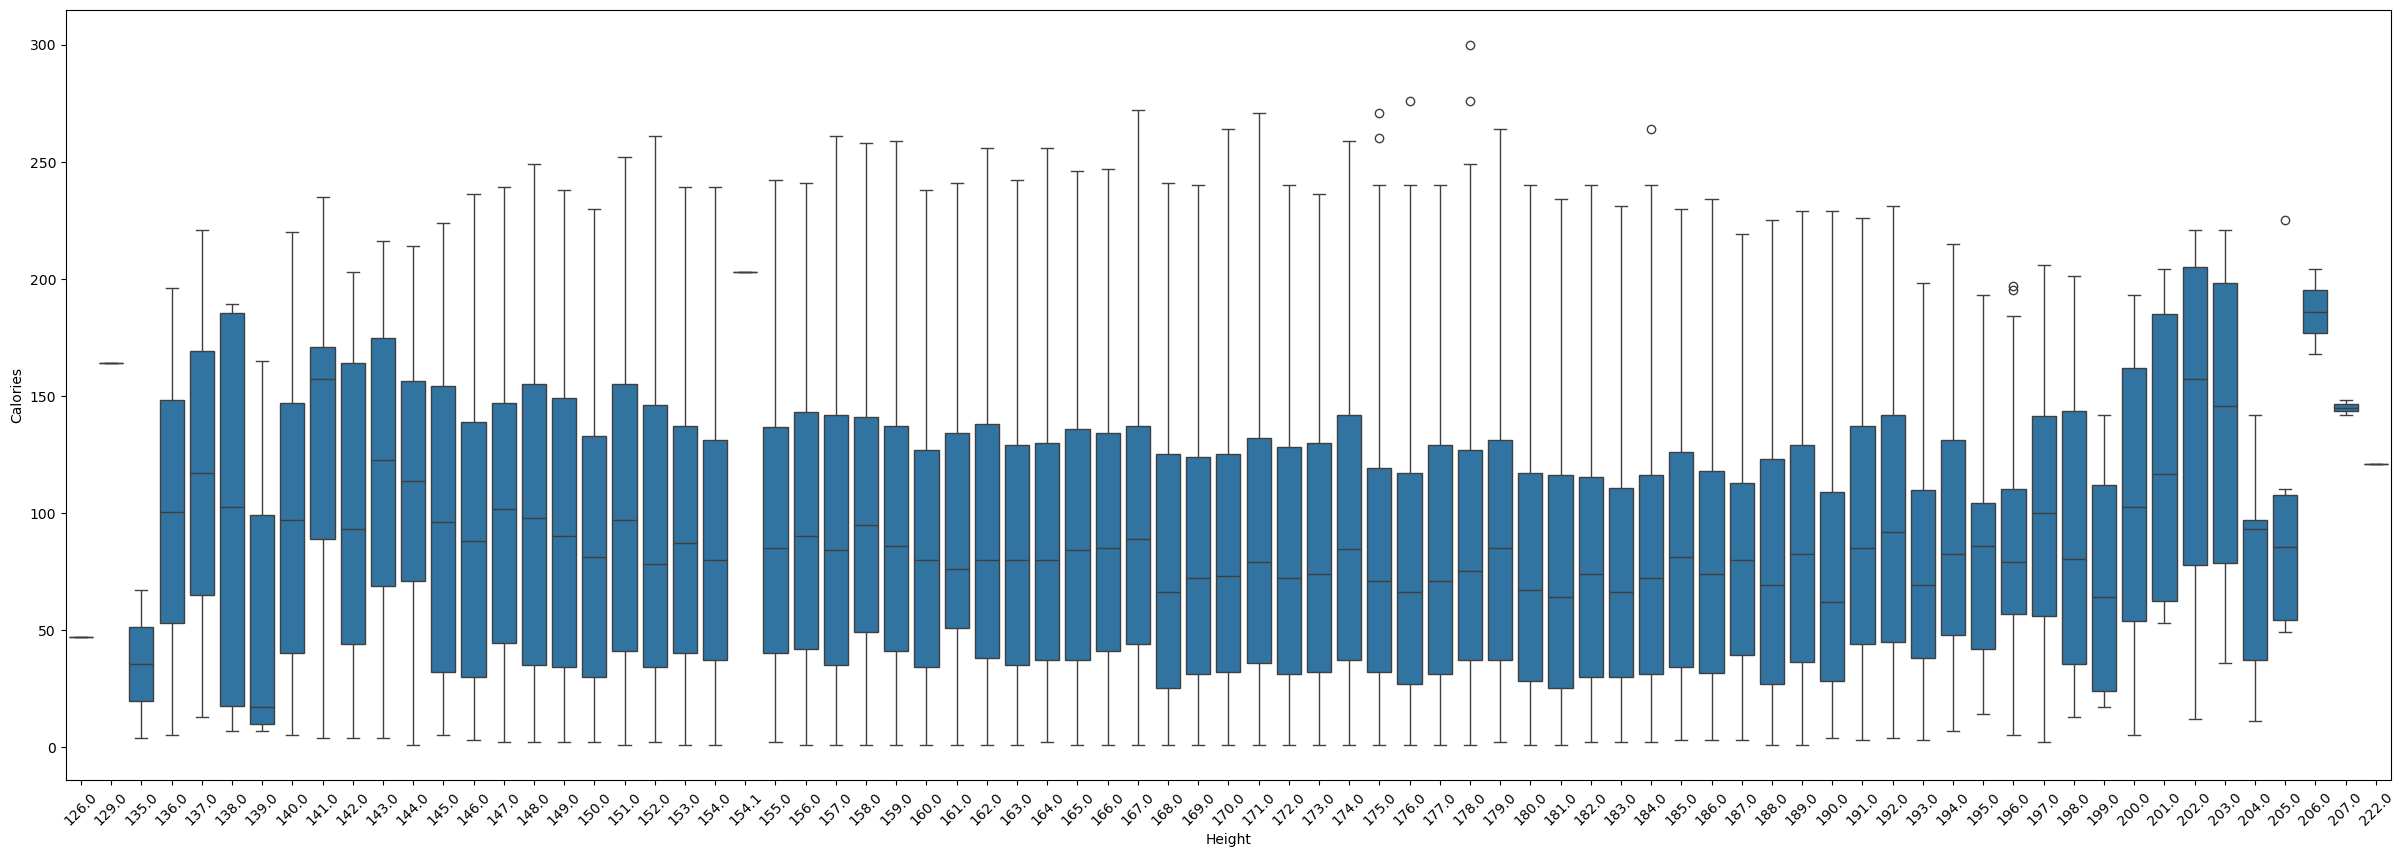

In [14]:
plotBoxplot(female_df, 'Height', 'Calories')

<Axes: >

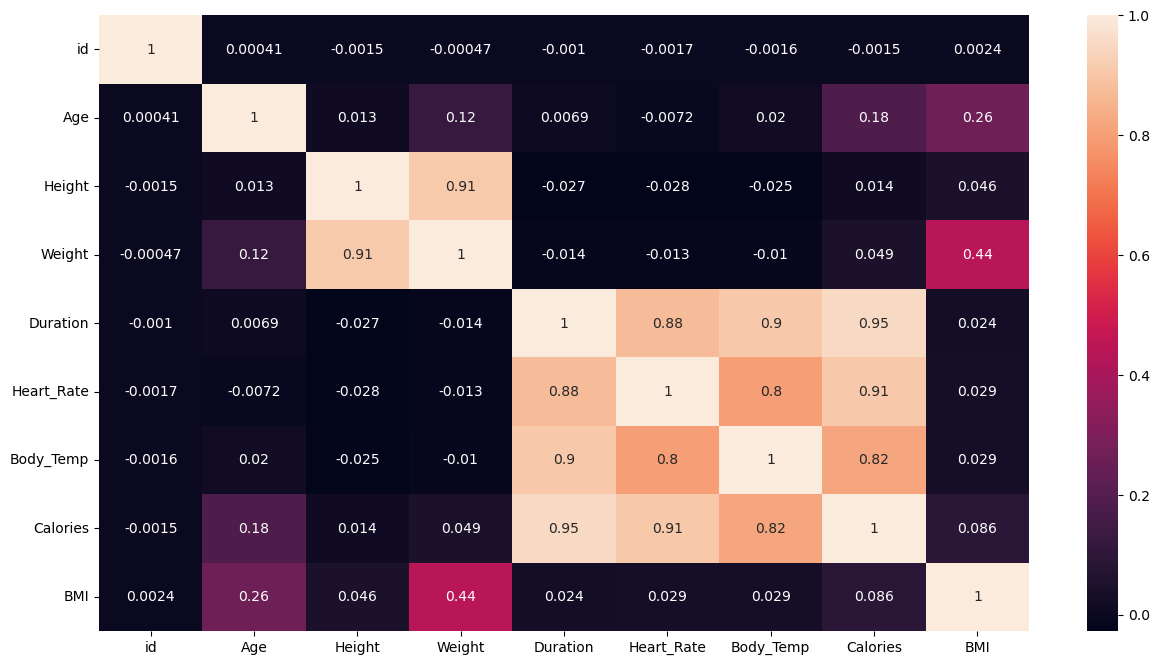

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(male_df.corr(numeric_only=True), annot=True)

<Axes: >

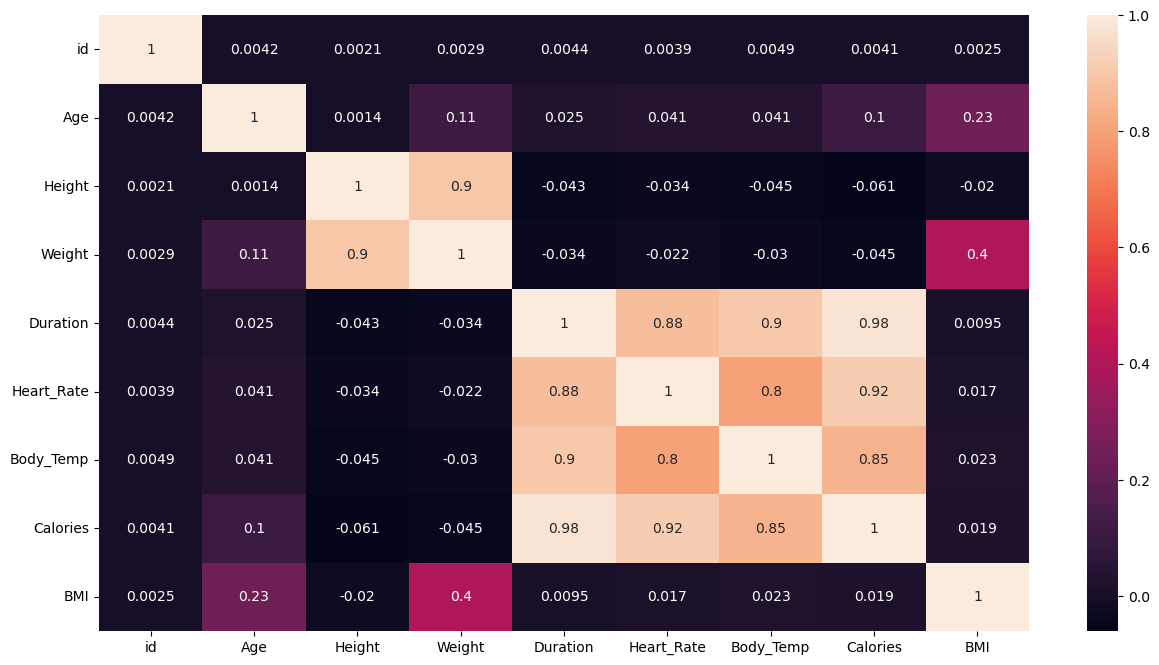

In [16]:
plt.figure(figsize=(15,8))
sns.heatmap(female_df.corr(numeric_only=True), annot=True)

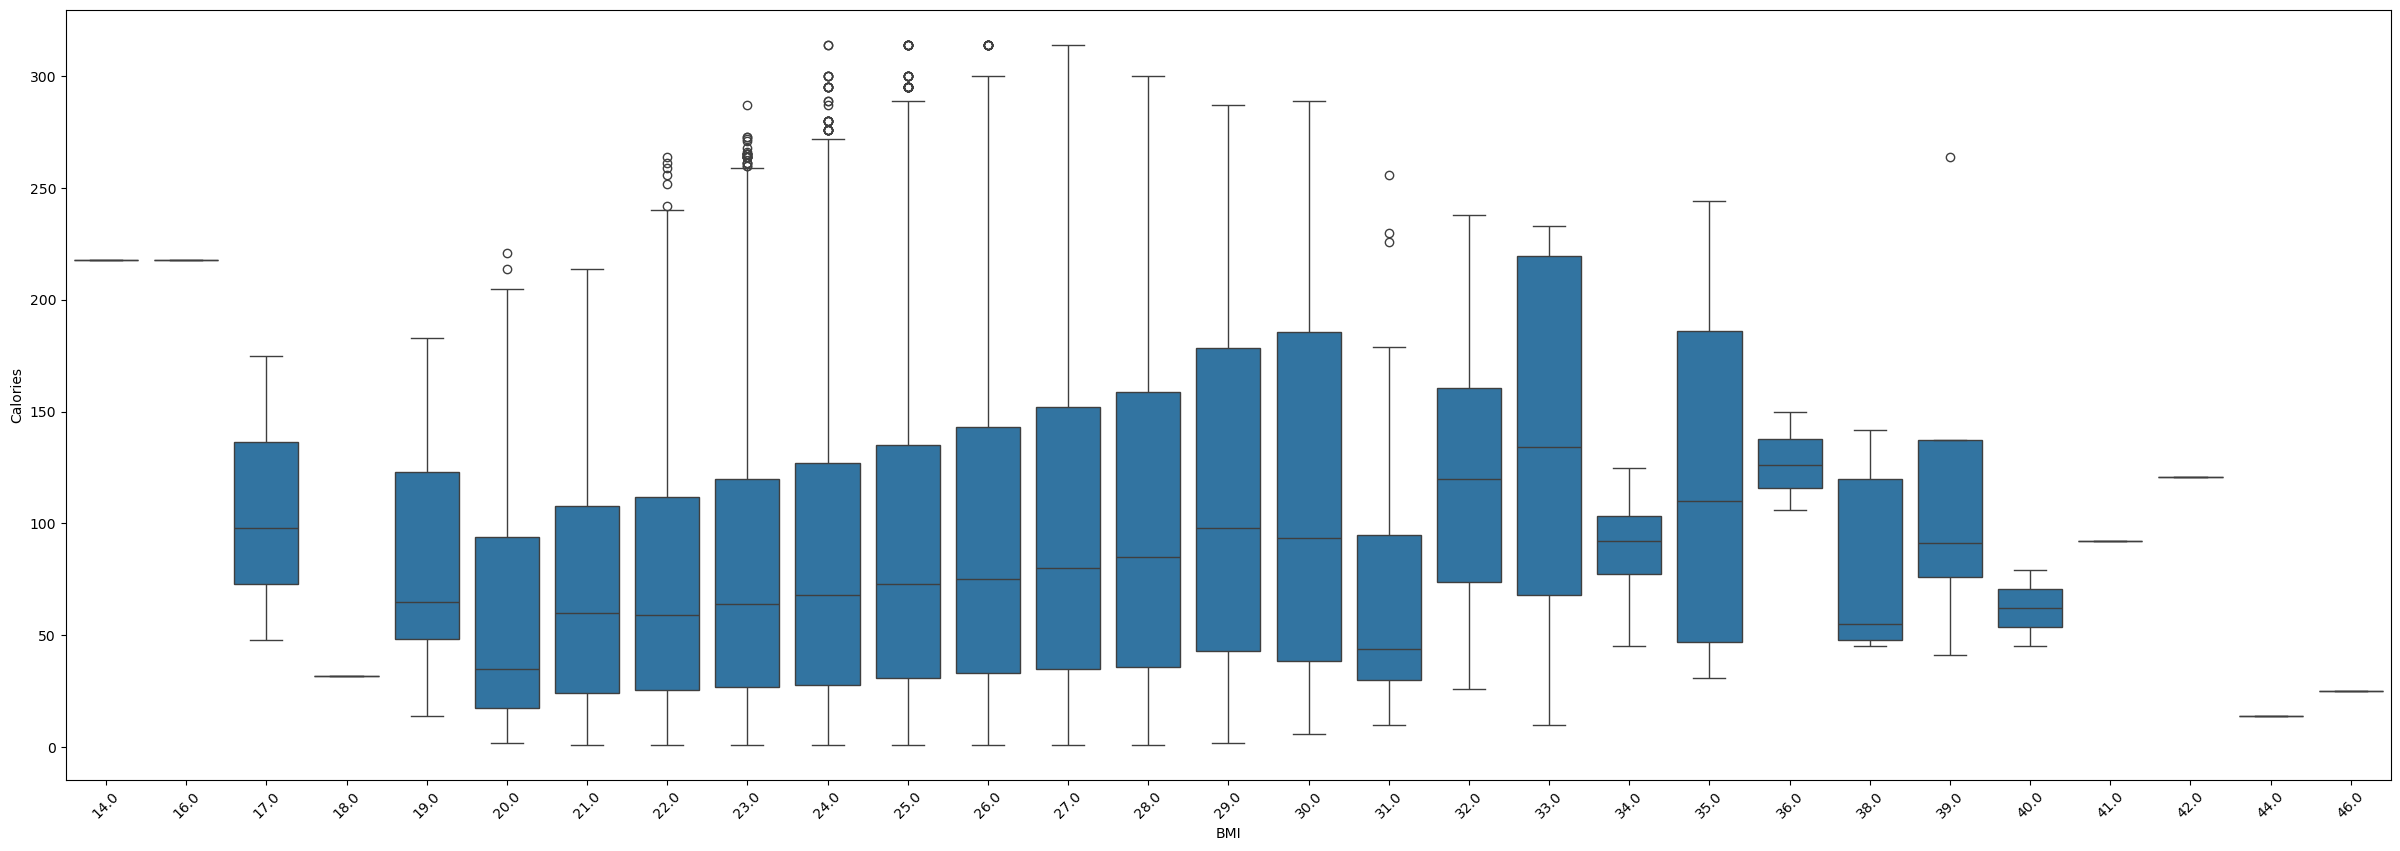

In [17]:
plotBoxplot(male_df, 'BMI', 'Calories')

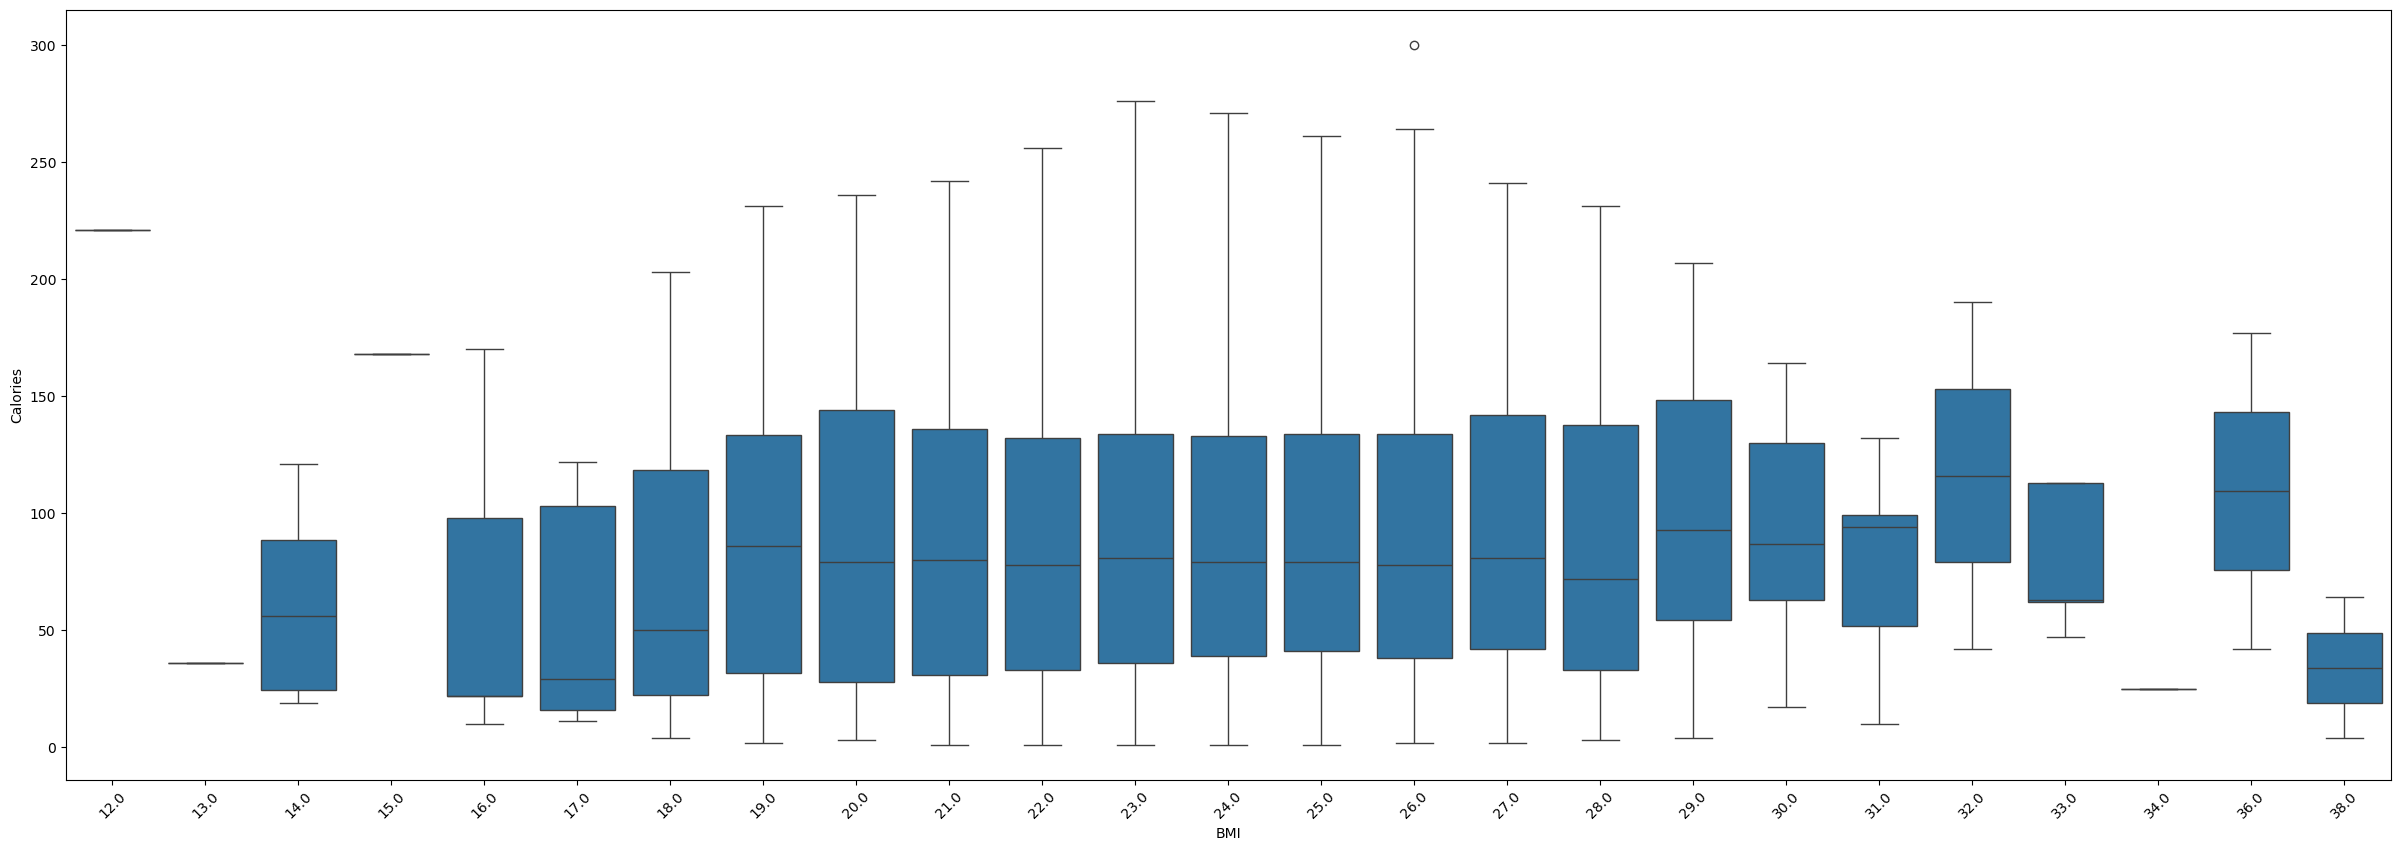

In [18]:
plotBoxplot(female_df, 'BMI', 'Calories')

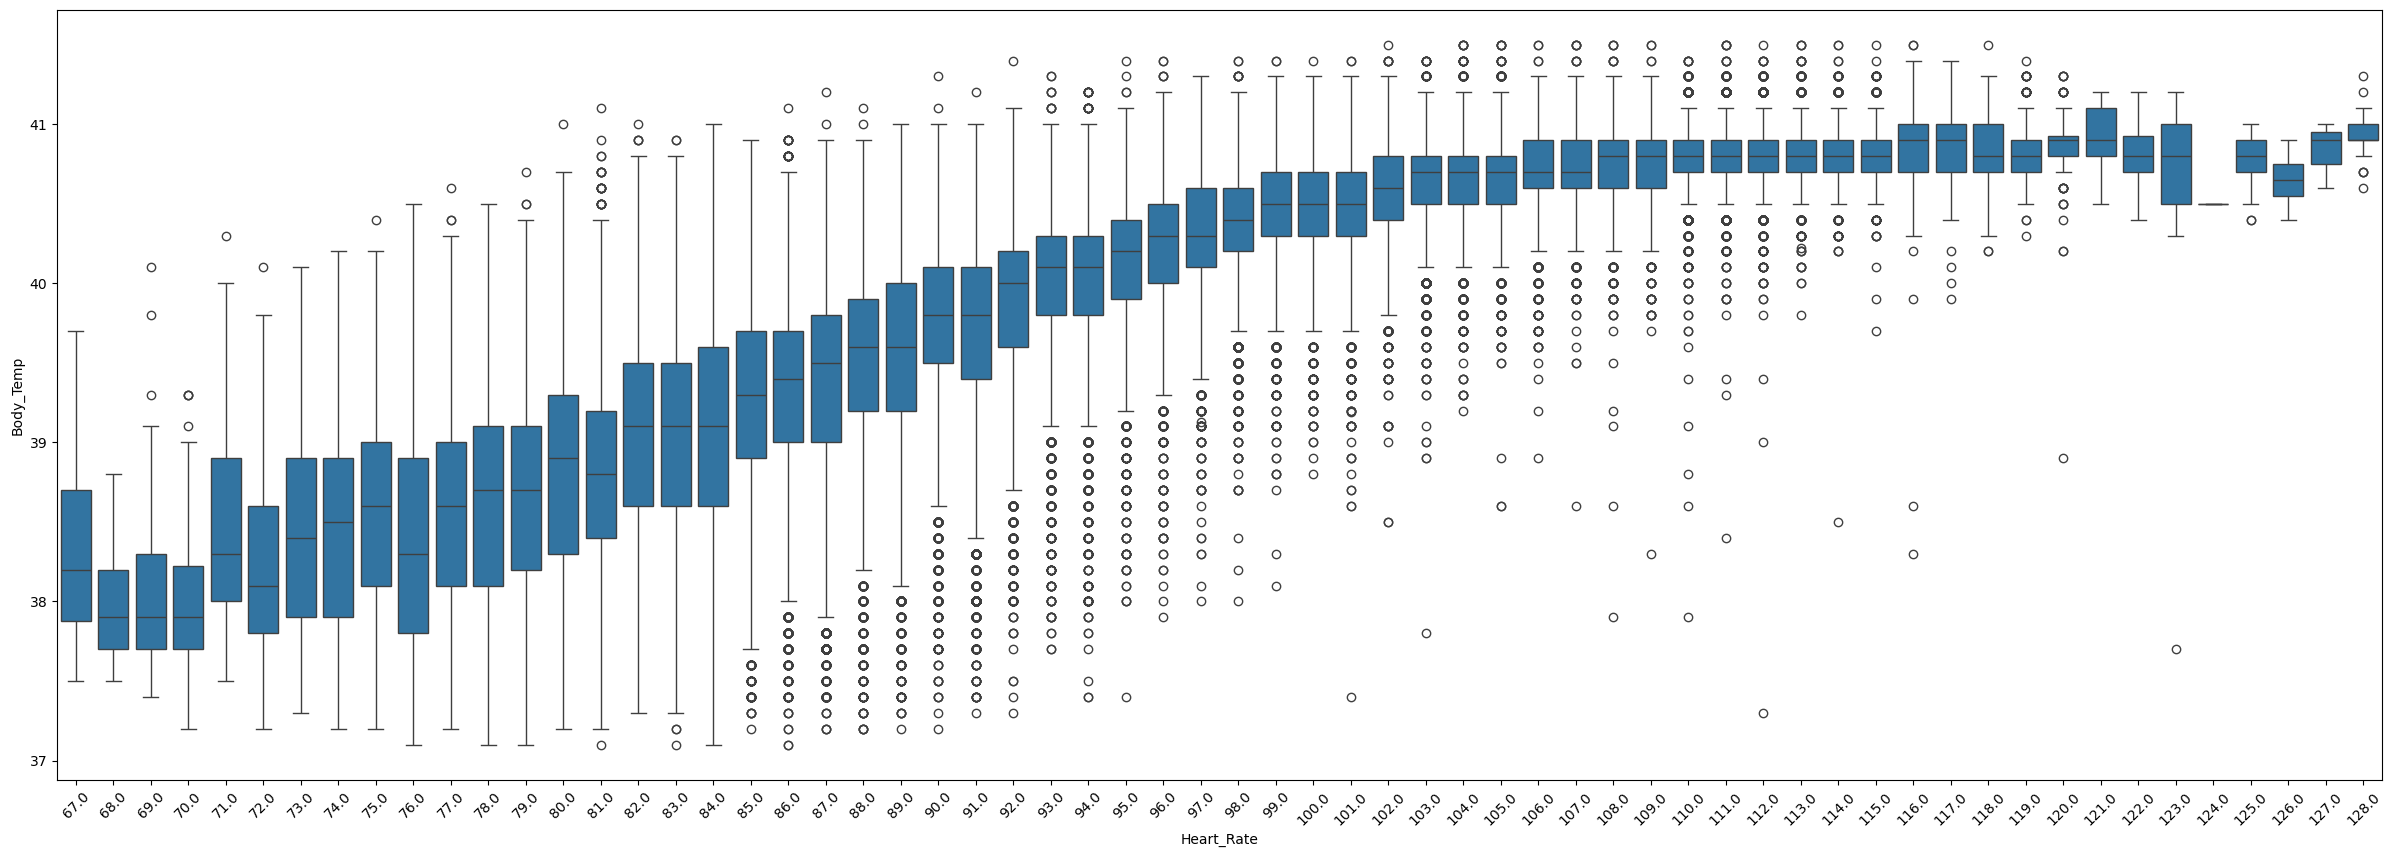

In [19]:
plotBoxplot(male_df, 'Heart_Rate', 'Body_Temp')

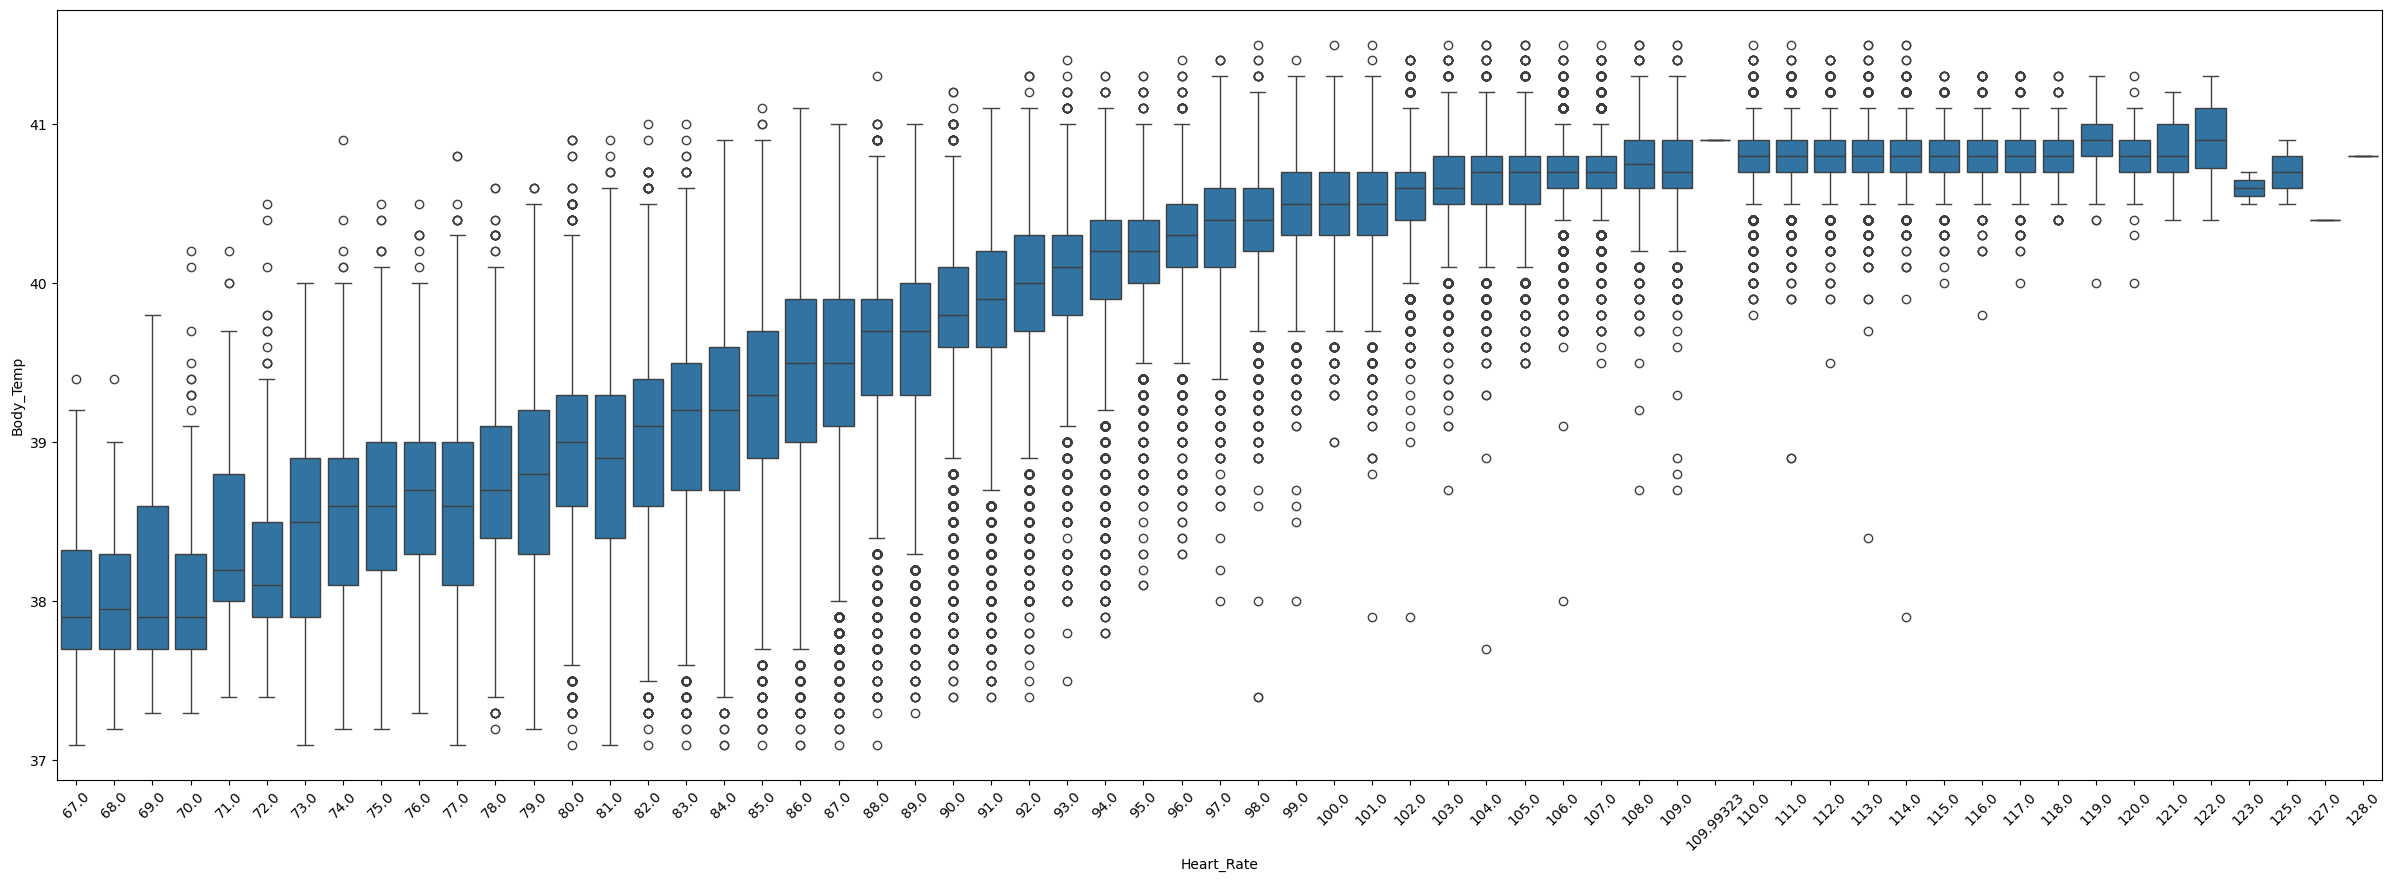

In [20]:
plotBoxplot(female_df, 'Heart_Rate', 'Body_Temp')

In [21]:
test_df = add_bmi(test_df)
test_df = add_columns(test_df)
train_df = add_bmi(train_df)
train_df = add_columns(train_df)

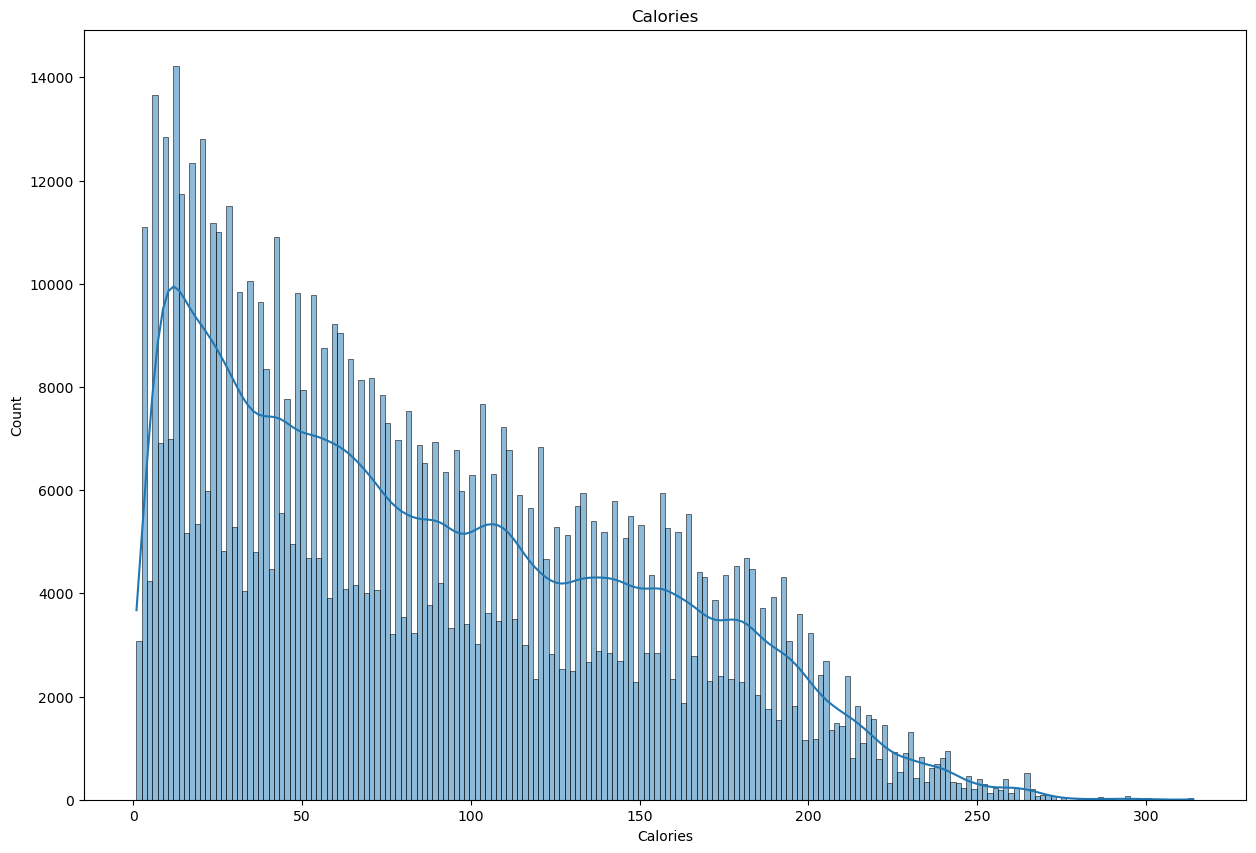

In [22]:
plt.figure(figsize=(15,10))
sns.histplot(train_df['Calories'], bins=200, kde=True)
plt.title('Calories')
plt.show()

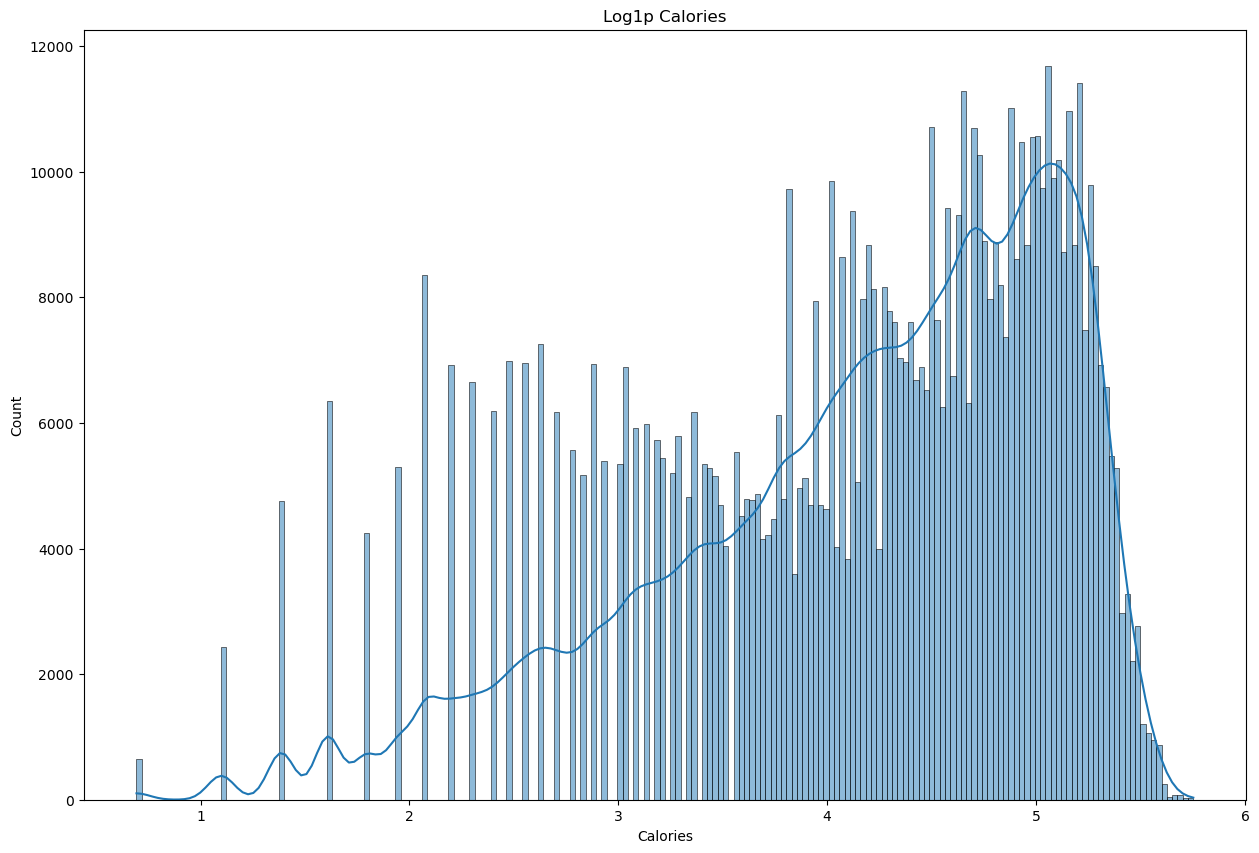

In [23]:
plt.figure(figsize=(15,10))
sns.histplot(np.log1p(train_df['Calories']), bins=200, kde=True)
plt.title('Log1p Calories')
plt.show()

In [24]:
X = drop_cols(train_df)
y = train_df['Calories']

### 이후 내용
1. train_test_split
2. XGBoost 모델 학습
3. RMSLE 계산 (inverse_transform 필요)
4. test_df 처리 및 예측
5. 제출 파일 생성
6. (선택) 모델 성능 향상 작업

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
qt = QuantileTransformer(output_distribution='normal')
# QuantileTransformer: 특정 분포로 데이터를 remapping 
# output_distribution='normal': 표분 정규분포로 전환 
y_train_qt = qt.fit_transform(y_train.values.reshape(-1, 1)).ravel()
# fit_transform: 분포 학습 + 변환 동시 실행 
y_valid_qt = qt.transform(y_valid.values.reshape(-1, 1)).ravel()
# train 기준으로 반환해야 일반화 되기에 transform만 진행
### 예측 후 반드시 inverse_transform으로 원래 스케일로 되돌려야 함

In [28]:
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=10  # 여기에 명시
)

model.fit(
    X_train, y_train_qt,
    eval_set=[(X_valid, y_valid_qt)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
y_pred_qt = model.predict(X_valid)

In [30]:
y_pred = qt.inverse_transform(y_pred_qt.reshape(-1, 1)).ravel()
y_valid_true = qt.inverse_transform(y_valid_qt.reshape(-1, 1)).ravel()

In [31]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

rmsle = np.sqrt(mean_squared_log_error(y_valid_true, y_pred))
print("RMSLE on validation set:", rmsle)

RMSLE on validation set: 0.06269202889082598


In [32]:
test_df = add_bmi(test_df)
test_df = add_columns(test_df)
test_df = test_df.drop(columns=['id', 'Sex'])

X_test = test_df.copy()  # 최종 feature만 사용
y_test_pred_qt = model.predict(X_test)
y_test_pred = qt.inverse_transform(y_test_pred_qt.reshape(-1, 1)).ravel()

In [33]:
submission = pd.DataFrame({
    'id': test_id,  # 원본 test.csv에서 불러온 id
    'Calories': y_test_pred
})
submission.to_csv('submission.csv', index=False)

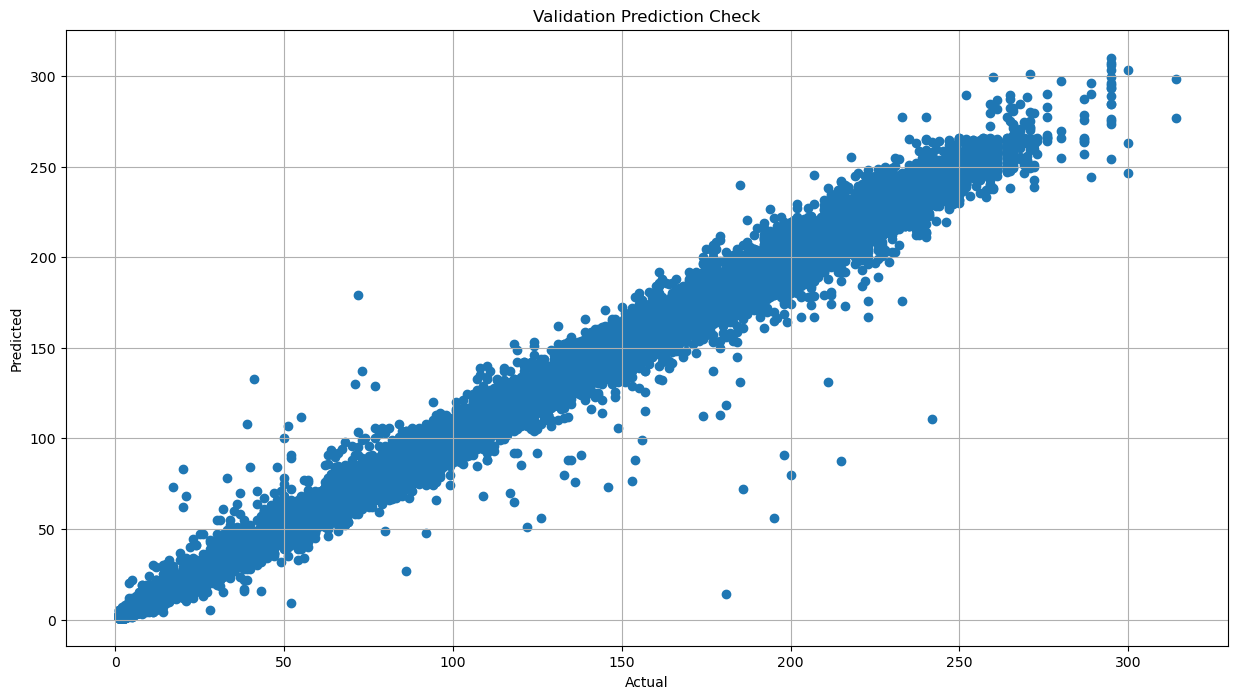

In [70]:
plt.figure(figsize=(15,8))
plt.scatter(y_valid, y_pred)  # 실제값 vs 예측값
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Validation Prediction Check")
plt.grid(True)
plt.show()

In [74]:
git remote add origin https://github.com/brocolies/Kaggle-Playground-Series-S5-E5.git
git branch -M main 
git push -u origin main

SyntaxError: invalid syntax (177621703.py, line 1)